<a href="https://colab.research.google.com/github/advapplab/sentiment_analysis_election_2022/blob/main/weibo_wmmBERT_testing_Cya_check_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0 Init

In [1]:
!pip install datasets
!pip install transformers
!pip install --upgrade xlrd
!pip install huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 20.3 MB/s 
     |████████████████████████████████| 132 kB 75.4 MB/s 
     |████████████████████████████████| 212 kB 65.6 MB/s 
     |████████████████████████████████| 182 kB 72.1 MB/s 
     |████████████████████████████████| 127 kB 71.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 18.7 MB/s 
     |████████████████████████████████| 7.6 MB 21.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96 kB 5.9 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.2.0
    Unins

In [2]:
#import our model from huggingface
number_classes = 2
model_tokenizer = "hfl/chinese-roberta-wwm-ext"

if number_classes == 2:
    model_classifier = "Jiabo/Roberta_Chinese_sentiment"
else:
    model_classifier = "owen198/weibo-wmmbert-6"


In [3]:
model_classifier

'Jiabo/Roberta_Chinese_sentiment'

# 1. load and clean data

In [4]:
! wget -nc https://raw.githubusercontent.com/advapplab/sentiment_analysis_election_2022/main/data/challange/df_sample.xlsx

--2022-12-19 09:43:52--  https://raw.githubusercontent.com/advapplab/sentiment_analysis_election_2022/main/data/challange/df_sample.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 111029 (108K) [application/octet-stream]
Saving to: ‘df_sample.xlsx’

df_sample.xlsx      100%[===================>] 108.43K  --.-KB/s    in 0.002s  

2022-12-19 09:43:52 (49.3 MB/s) - ‘df_sample.xlsx’ saved [111029/111029]



In [5]:
ici_map_dict = dict()

if number_classes == 6:

    ici_map_dict['angry']=0
    ici_map_dict['anger']=0
    ici_map_dict['positive']=1
    ici_map_dict['posiitive']=1
    ici_map_dict['happy']=1
    ici_map_dict['neutral']=2
    ici_map_dict['neural']=2
    ici_map_dict['surprise']=3
    ici_map_dict['suprise']=3
    ici_map_dict['sad']=4
    ici_map_dict['negative']=4
    ici_map_dict['fear']=5
else:
    ici_map_dict['positive']=1 #pos
#    ici_map_dict['posiitive']=1 #pos
#    ici_map_dict['neutral']=3 #ignore
#    ici_map_dict['surprise']=3 #ignore
    ici_map_dict['negative']=0 #neg
 

len(ici_map_dict)

2

In [6]:
import pandas as pd

In [7]:
testing_pd = pd.read_excel('/content/df_sample.xlsx')

testing_pd = testing_pd[['text', 'cya_check_3']]
testing_pd = testing_pd.rename(columns={'cya_check_3':'label'})
testing_pd = testing_pd[(testing_pd['label'] == 'negative') | (testing_pd['label'] == 'positive')]


# align labels
# testing_pd['label'].unique()
testing_pd['label'] = testing_pd['label'].str.lower()
testing_pd['label'] = testing_pd['label'].str.split(' ', 0, expand = True)[0]
testing_pd['label'] = testing_pd['label'].str.split(',', 0, expand = True)[0]
testing_pd['label'] = testing_pd['label'].map(ici_map_dict).astype('int')

testing_pd.shape

(123, 2)

In [8]:
#dirty data
testing_pd

,text,label
3,【这家民调蒋万安拉警报？ 郭正亮惊爆内幕：帮陈时中冲喜】对于《东森新闻》委托“雨晴民调公司”...,0
4,"【陈时中称蒋万安防疫主张抄袭自己 蒋万安：他防疫做得这么差 谁会想抄】<a href=""h...",0
5,【黑心快筛流入蒋万安：食药署责无旁贷、不是推给厂商就可卸责】针对黑心快筛流入市面，国民党台北...,0
6,"<a href=""https://m.weibo.cn/search?containeri...",0
7,很多人根本看不懂国际局势<br />一方面是信息获取能力缺乏导致，更重要的是骨子里缺钙导致。...,0
...,...,...
193,【蓝绿互打政二代 港媒预言最惨结局与最后赢家】国民党台北市议员徐巧芯日前公布民进党台北市长参...,0
194,2022/9/17 周玉蔻攻擊慈濟完再攻擊蔣萬安，蔣應砲火全開回擊，贏回藍營的搖擺選民<br...,0
197,【周玉蔻怎能霸占黄金时段？郭正亮爆：被“有分量”金主标下】资深媒体人周玉蔻日前攻击国民党台北...,0
198,额？？？这是蒋万安的竞选团队？？？,0


In [9]:
#we can consider not deleting the titles. This will be up to the ICI project group to decide
testing_pd = testing_pd[~testing_pd['text'].str.contains('a href', regex=True)]

# TODO: we should remove non-Chinese characters in 'text column'
import re
html_pattern = "<(?:\"[^\"]*\"['\"]*|'[^']*'['\"]*|[^'\">])+>"
http_pattern = "http\S+"
image_pattern = "<img\s[^>]*?src\s*=\s*['\"]([^'\"]*?)['\"][^>]*?>" 
title_pattern = "[【|《*】|》]"
title_pattern_1 = "(?=【)(.*)(?<=】)"
title_pattern_2 = "(?=《)(.*)(?<=》)"
link_pattern="网页链接"
span_pattern='<span.*?>(.+?)</span>'

#we have to find a way to delete the entire <span> tag. some posts will end up with only 2 or 3 characters after that. We can drop them. 



testing_pd['text'] = testing_pd['text'].replace(span_pattern,'',regex=True).replace(span_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(http_pattern,'',regex=True).replace(html_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(image_pattern,'',regex=True).replace(title_pattern_1,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(link_pattern,'',regex=True).replace(html_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(title_pattern_2,'',regex=True)

if number_classes == 6:
    pass
else:
    testing_pd = testing_pd[testing_pd['label'] != 3]

testing_pd = testing_pd.dropna().reset_index(drop=True)

<ipython-input-9-e80b1016d358>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_pd['text'] = testing_pd['text'].replace(span_pattern,'',regex=True).replace(span_pattern,'',regex=True)
<ipython-input-9-e80b1016d358>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_pd['text'] = testing_pd['text'].replace(http_pattern,'',regex=True).replace(html_pattern,'',regex=True)
<ipython-input-9-e80b1016d358>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

In [10]:
#clean data
testing_pd

,text,label
0,对于委托“雨晴民调公司”进行民意调查，台北市长“支持度”部分，民进党陈时中为25.8％，国民...,0
1,,0
2,针对黑心快筛流入市面，国民党台北市长参选人蒋万安今天说，食药署当然责无旁贷，绝对不是说推给黑...,0
3,,0
4,很多人根本看不懂国际局势一方面是信息获取能力缺乏导致，更重要的是骨子里缺钙导致。直白一点说，...,0
...,...,...
114,说什么蒋经国不是蒋介石亲生的，蒋介石没有后，纯属扯淡，蒋友柏和蒋介石很像好吗,0
115,国民党台北市议员徐巧芯日前公布民进党台北市长参选人陈时中竞选办公室分机通讯录，名单中竟有许多...,0
116,2022/9/17 周玉蔻攻擊慈濟完再攻擊蔣萬安，蔣應砲火全開回擊，贏回藍營的搖擺選民變色媒...,0
117,资深媒体人周玉蔻日前攻击国民党台北市长候选人蒋万安，指其父绯闻女主角是张淑娟，还在遭按铃申告...,0


In [11]:
#delete empty rows
testing_pd = testing_pd[testing_pd['text'].str.len()>2]   
testing_pd = testing_pd[['text', 'label']]
testing_pd = testing_pd.reset_index(drop=True)
testing_pd

,text,label
0,对于委托“雨晴民调公司”进行民意调查，台北市长“支持度”部分，民进党陈时中为25.8％，国民...,0
1,针对黑心快筛流入市面，国民党台北市长参选人蒋万安今天说，食药署当然责无旁贷，绝对不是说推给黑...,0
2,很多人根本看不懂国际局势一方面是信息获取能力缺乏导致，更重要的是骨子里缺钙导致。直白一点说，...,0
3,大概是个什么样子的？光阴似箭日月如梭，70年说长不长说短不短，已然超过一个甲子了。我们都知道...,1
4,资深媒体人周玉蔻因指控张淑娟为蓝营台北市长参选人蒋万安父亲陈年绯闻的女主角而挨告，现身北检鞠...,0
...,...,...
111,说什么蒋经国不是蒋介石亲生的，蒋介石没有后，纯属扯淡，蒋友柏和蒋介石很像好吗,0
112,国民党台北市议员徐巧芯日前公布民进党台北市长参选人陈时中竞选办公室分机通讯录，名单中竟有许多...,0
113,2022/9/17 周玉蔻攻擊慈濟完再攻擊蔣萬安，蔣應砲火全開回擊，贏回藍營的搖擺選民變色媒...,0
114,资深媒体人周玉蔻日前攻击国民党台北市长候选人蒋万安，指其父绯闻女主角是张淑娟，还在遭按铃申告...,0


In [12]:
#upsize minority class (positive). You can consider turning this cell off. With the current data (df_sample.xlsx) this will lead to a 0.840 accuracy. 
if number_classes == 2:
    from sklearn.utils import resample

    df_majority = testing_pd[testing_pd.label==0]
    df_minority = testing_pd[testing_pd.label==1]

    # Upsample minority class
    df_minority_upsampled = resample(df_minority, 
                                    replace=True,     # sample with replacement
                                    n_samples=df_majority.shape[0],    # to match majority class
                                    random_state=42) # reproducible results

    # Combine majority class with upsampled minority class
    testing_pd = pd.concat([df_majority, df_minority_upsampled])


In [13]:
num_label = len(testing_pd['label'].unique())
num_label

2

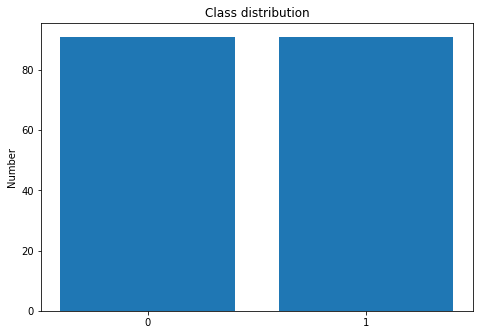

In [14]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(testing_pd['label'].unique(),
       testing_pd.groupby(['label']).count()['text'].tolist())

ax.set_xticks(testing_pd.groupby(['label']).count().index.values)

ax.set_ylabel('Classes')
ax.set_ylabel('Number')
ax.set_title('Class distribution')
plt.show()

## 1-2 Tokenization

In [15]:
from datasets import Dataset, DatasetDict

weibo_dict = {
              'test' : Dataset.from_pandas(testing_pd)}

weibo_ds = DatasetDict(weibo_dict)

In [16]:
from transformers import AutoTokenizer

In [17]:
tokenizer = AutoTokenizer.from_pretrained(model_tokenizer)

Downloading:   0%|          | 0.00/19.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/689 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/110k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/269k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [18]:
def tokenize_function(examples):
    return tokenizer(examples["text"], 
                     padding="max_length", 
                     truncation=True, 
                     max_length=512)

tokenized_datasets = weibo_ds.map(tokenize_function, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [19]:
full_test_dataset = tokenized_datasets["test"]

# 2. Testing

In [20]:
from transformers import AutoModelForSequenceClassification

# available chinese models: https://github.com/ymcui/Chinese-BERT-wwm

model = AutoModelForSequenceClassification.from_pretrained(model_classifier, 
                                                           num_labels=num_label)

Downloading:   0%|          | 0.00/958 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/409M [00:00<?, ?B/s]

In [21]:
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

<ipython-input-21-e1ee7db0da93>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


## 2-1 Get Accuracy

In [22]:
from transformers import Trainer

trainer = Trainer(
    model=model, 
    eval_dataset=full_test_dataset,
    compute_metrics=compute_metrics,
)

In [23]:
import numpy as np

# trainer.evaluate()

In [24]:
pred = trainer.predict(test_dataset=full_test_dataset)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 182
  Batch size = 8


In [25]:
#get test accuracy
pred.metrics

{'test_loss': 0.2642820477485657,
 'test_accuracy': 0.9065934065934066,
 'test_runtime': 8.519,
 'test_samples_per_second': 21.364,
 'test_steps_per_second': 2.7}

In [26]:
pred

PredictionOutput(predictions=array([[ 2.7329338 , -1.9903389 ],
       [ 2.932102  , -2.2149487 ],
       [ 3.1424763 , -2.5138896 ],
       [ 2.0176303 , -1.2905198 ],
       [ 0.7684566 , -0.49818414],
       [ 3.452411  , -2.852465  ],
       [ 3.3725777 , -2.7716606 ],
       [ 1.686373  , -0.9774492 ],
       [ 2.551974  , -1.7880154 ],
       [ 2.551879  , -1.7904227 ],
       [-1.8651242 ,  1.0463231 ],
       [ 3.6411436 , -3.0478039 ],
       [ 3.1073637 , -2.4135363 ],
       [ 3.3686855 , -2.768367  ],
       [ 2.27407   , -1.5125974 ],
       [-2.499348  ,  1.6431243 ],
       [ 3.059784  , -2.3877943 ],
       [ 3.3062923 , -2.6848514 ],
       [ 2.9592314 , -2.251493  ],
       [ 3.5792277 , -3.0115016 ],
       [ 3.060105  , -2.3877325 ],
       [ 3.2208755 , -2.5912244 ],
       [ 2.6665497 , -1.9215509 ],
       [ 3.9743862 , -3.4039094 ],
       [ 3.0873437 , -2.460598  ],
       [ 3.6469424 , -3.0490477 ],
       [ 2.0717266 , -1.3131843 ],
       [ 1.9376128 , -1.22

In [27]:
# logits, labels = pred.predictions
np.argmax(pred.predictions, axis=-1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

In [28]:
testing_pd['pred'] = np.argmax(pred.predictions, axis=-1)

# 3. Analyse predictions

In [29]:

#look at all the results
testing_pd

,text,label,pred
0,对于委托“雨晴民调公司”进行民意调查，台北市长“支持度”部分，民进党陈时中为25.8％，国民...,0,0
1,针对黑心快筛流入市面，国民党台北市长参选人蒋万安今天说，食药署当然责无旁贷，绝对不是说推给黑...,0,0
2,很多人根本看不懂国际局势一方面是信息获取能力缺乏导致，更重要的是骨子里缺钙导致。直白一点说，...,0,0
4,资深媒体人周玉蔻因指控张淑娟为蓝营台北市长参选人蒋万安父亲陈年绯闻的女主角而挨告，现身北检鞠...,0,0
5,名嘴周玉蔻日前在媒体上攻击蒋万安父亲蒋孝严20几年前诽闻，并且在台北地检署前面与国民党台北市...,0,0
...,...,...,...
28,年底台北市长“三脚督”底定，有意参战的台北市副市长黄珊珊23日上午出席活动时，受到大同区至圣...,1,1
93,"台北市民调各有领先,陈时中称比赛刚开始,蒋万安:一定会赢",1,1
58,民进党台北市长参选人陈时中、台北市副市长黄珊珊透过新书别苗头。国民党台北市长参选人蒋万安今预...,1,1
52,年底九合一选战渐热，传民进党安排林佳龙转战新北，陈时中则出征北市，形成「龙中配」，而国民党新...,1,1


In [30]:
#see where BERT got it wrong. The count column stands for how many comma's the sentence has... In case we want to consider removing some sentences. 
mistakes_pd = testing_pd.loc[testing_pd['label'] != testing_pd['pred']]
mistakes_pd = (mistakes_pd.reset_index()
        .drop_duplicates(subset='index', keep='last')
        .set_index('index').sort_index())
mistakes_pd['count'] = mistakes_pd['text'].str.count('，')
mistakes_pd.sort_values(by="count")

,text,label,pred,count
index,,,,
11,"我分享了, 快来看吧！ |",0,1,0
104,曹叡比蒋经国更孝顺母亲！,0,1,0
19,媒体人周玉蔻近期猛攻国民党台北市长候选人蒋万安家族，更公开高喊“我就是爱阿中！”国民党台北市...,1,0,5
80,民进党台北市长参选人陈时中团队成员遭指“政二代”，民进党立委许智杰反批国民党台北市长参选人蒋...,0,1,6
100,年底台北市长选战竞争激烈，民进党参选人陈时中在8日播出的专访中再度点评对手，认为国民党立委蒋...,0,1,7
63,毛福梅（1882年～1939年12月12日），女，汉族，浙江奉化岩头村人。1901年与时年1...,0,1,8
83,年底台北之战备受关注，台北市长参选人蒋万安昨接受本报专访时表示，有人说台北市副市长黄珊珊“根...,0,1,8
113,2022/9/17 周玉蔻攻擊慈濟完再攻擊蔣萬安，蔣應砲火全開回擊，贏回藍營的搖擺選民變色媒...,0,1,8
17,陈时中卸任在即，将要辞职转战投入台北市长选举，虽因此被不少民众抱怨为“落跑指挥官”，但媒体人...,0,1,9


In [31]:
#see where BERT got it right
correct_pd = testing_pd.loc[testing_pd['label'] == testing_pd['pred']]
correct_pd = (correct_pd.reset_index()
        .drop_duplicates(subset='index', keep='last')
        .set_index('index').sort_index())
correct_pd['count'] = correct_pd['text'].str.count('，')
correct_pd.sort_values(by="count")

,text,label,pred,count
index,,,,
115,额？？？这是蒋万安的竞选团队？？？,0,0,0
106,周玉蔻这条沙皮狗继续狂咬蒋万安父子,0,0,0
56,周玉蔻再次发文抨击蒋万安不是蒋家的种,0,0,0
57,蒋万安：绝不低头,1,1,0
93,"台北市民调各有领先,陈时中称比赛刚开始,蒋万安:一定会赢",1,1,0
...,...,...,...,...
103,民进党桃园市长参选人林智坚论文争议持续发酵。据台湾中时新闻网9日最新消息，台当局领导人蔡英文...,0,0,34
32,国民党告陈时中渎职 质疑其疫苗采购黑箱操作 中新网9月22日电 据台湾报道，国民党认为参选...,0,0,41
37,综合台媒报道，台媒体人周玉蔻近期争议言论不断，面对外界批评，她透过其创办的放言传媒有限公司...,0,0,44


In [32]:
#correct_count_pd = correct_pd['text'].str.len()
#pd.DataFrame(correct_count_pd)